In [41]:
import importlib
import utils
importlib.reload(utils)
from utils import extract_pool,model_grps_config
import utils.optim_utils
importlib.reload(utils.optim_utils)
from utils.optim_utils import optim, optim_pool, pt_create_corr_rdm_short
from utils.data_utils import load_obj, SAVE_DIR, UD_PARENT, RESULTS_DIR, LEX_PATH_SET, save_obj
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
from tqdm import tqdm
import tsnecuda
import seaborn as sns 
import pandas as pd 
import os 
from sklearn.model_selection import LeaveOneOut
ANALYZE_DIR='/om/user/ehoseini/MyData/sent_sampling/analysis/'
from tqdm import tqdm
import tqdm.notebook as tq
from tqdm import tqdm_notebook
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [59]:
mdl_name='t5-3b'
group=f'{mdl_name}_layers'
#group='roberta-base_layers' 
#group='xlnet-large-cased_layers' "
#group='bert-large-uncased-whole-word-masking_layers' "
#group='xlm-mlm-en-2048_layers' "
#group='albert-xxlarge-v2_layers' "
#group='ctrl_layers' "
dataset='coca_spok_filter_punct_10K_sample_1' 
activatiion_type='activation' 
average='None' 
extractor_id=f'group={group}-dataset={dataset}-{activatiion_type}-bench=None-ave={average}'
#extractor_id='group=xlm-mlm-en-2048_layers-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=False'

extractor_obj = extract_pool[extractor_id]()
extractor_obj.load_dataset()
model_layers = extractor_obj.layer_name
extractor_obj()
mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())

KeyError: 'group=t5-3b_layers-dataset=coca_spok_filter_punct_10K_sample_1-activation-bench=None-ave=None'

In [56]:
optimizer_id='coordinate_ascent_eh-obj=D_s_var-n_iter=50-n_samples=25-n_init=1-run_gpu=True'
optim_obj=optim_pool[optimizer_id]()

In [57]:
all_layer_curve=[]
all_layer_curve_all=[]
for layer_act in extractor_obj.model_group_act:
    sent_act_list=layer_act['activations']
    #sent_act=[torch.tensor(x[0], dtype=float, device=optim_obj.device, requires_grad=False) for x in sent_act_list]
    sent_act=[x[0] for x in sent_act_list]
    sent_act=[np.diff(x,axis=0) for x in sent_act]
    sent_act=[normalized(x) for x in sent_act]
    curvature=[]
    for idy , vec in tqdm(enumerate(sent_act)):
        curve=[np.arccos(np.dot(vec[idx,:],vec[idx+1,:])) for idx in range(vec.shape[0]-1)]
        curvature.append(curve)
    all_layer_curve.append([np.mean(x) for x in curvature])
    all_layer_curve_all.append(curvature)


0it [00:00, ?it/s]
2951it [00:00, 29503.28it/s]
5902it [00:00, 27092.47it/s]
10000it [00:00, 15698.47it/s][A

0it [00:00, ?it/s]
3341it [00:00, 33402.15it/s]
6682it [00:00, 31776.22it/s]
10000it [00:00, 30183.77it/s][A

0it [00:00, ?it/s]
2727it [00:00, 27263.40it/s]
5898it [00:00, 29872.27it/s]
10000it [00:00, 29452.93it/s][A

0it [00:00, ?it/s]
3260it [00:00, 32597.62it/s]
6520it [00:00, 31526.47it/s]
10000it [00:00, 29610.42it/s][A

0it [00:00, ?it/s]
2303it [00:00, 23020.58it/s]
5360it [00:00, 27442.52it/s]
10000it [00:00, 27175.58it/s][A

0it [00:00, ?it/s]
3157it [00:00, 31564.69it/s]
6314it [00:00, 28495.54it/s]
10000it [00:00, 26518.30it/s][A

0it [00:00, ?it/s]
2323it [00:00, 23220.11it/s]
5473it [00:00, 28077.39it/s]
10000it [00:00, 28200.89it/s][A

0it [00:00, ?it/s]
3288it [00:00, 32877.05it/s]
6576it [00:00, 31841.30it/s]
10000it [00:00, 29837.60it/s][A

0it [00:00, ?it/s]
3226it [00:00, 32252.49it/s]
6452it [00:00, 31787.49it/s]
10000it [00:00, 30796.16it/s][A

0it [00:0

Text(0.5, 1.0, 'gpt2_layers \n coca_spok_filter_punct_10K_sample_1 \n full sentence')

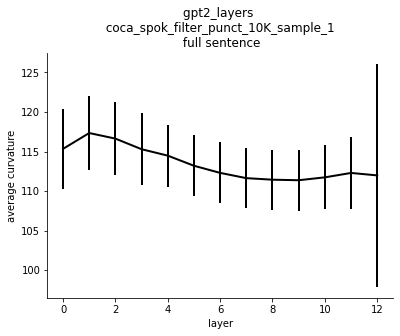

In [58]:
fig=plt.figure(figsize=(8,4))
ax = fig.add_axes((.3,.1,.6,.85))

ax.errorbar(np.arange(len(all_layer_curve)),np.mean(all_layer_curve,axis=1)*180/np.pi,yerr=np.std(all_layer_curve,axis=1)*180/np.pi,linewidth=2, color=(0,0,0))
ax.set_ylabel('average curvature')
ax.set_xlabel('layer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f"{group} \n {dataset} \n full sentence")


#ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
#ax.set_yticklabels(model_names,fontsize=14,fontweight='bold')
#ax.set_xlabel('score',fontsize=14)
#plt.xticks(fontsize=14)

IndexError: list index out of range

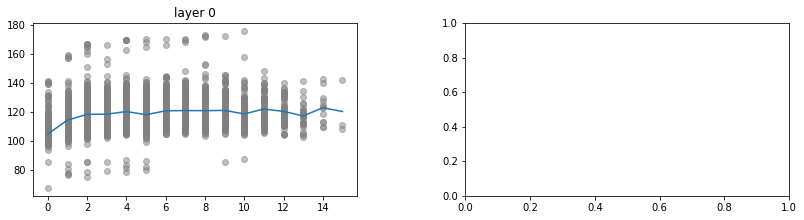

In [46]:
len(all_layer_curve_all[1][2])
random_set=np.random.randint(0,len(all_layer_curve_all[1]),size=500)
fig=plt.figure(figsize=(15,4))
ax = fig.add_axes((.1,.1,.3,.6))

selected_layer=0
all_length=[len(all_layer_curve_all[selected_layer][s]) for s in random_set]
sentence_datapoints=[(all_layer_curve_all[selected_layer][s]) for s in random_set]
sentence_fixed=np.stack([np.concatenate([np.asarray(x).flatten(),np.repeat(np.nan,np.max(all_length)-len(x)).flatten()],axis=0) for x in sentence_datapoints])

for s in random_set:
    curves=np.asarray(all_layer_curve_all[selected_layer][s])
    ax.scatter(np.arange(curves.shape[0]),curves*180/np.pi,color=(.5,.5,.5),alpha=.5)
ax.plot(np.nanmean(sentence_fixed*180/np.pi,axis=0),zorder=10)
ax.set_title(f'layer {selected_layer}')

ax = fig.add_axes((.5,.1,.3,.6))
selected_layer=7
all_length=[len(all_layer_curve_all[selected_layer][s]) for s in random_set]
sentence_datapoints=[(all_layer_curve_all[selected_layer][s]) for s in random_set]
sentence_fixed=np.stack([np.concatenate([np.asarray(x).flatten(),np.repeat(np.nan,np.max(all_length)-len(x)).flatten()],axis=0) for x in sentence_datapoints])

for s in random_set:
    curves=np.asarray(all_layer_curve_all[selected_layer][s])
    ax.scatter(np.arange(curves.shape[0]),curves*180/np.pi,color=(.5,.5,.5),alpha=.5)
ax.plot(np.nanmean(sentence_fixed*180/np.pi,axis=0))
ax.set_title(f'layer {selected_layer}')
plt.suptitle(f"{group} \n {dataset} \n sub sentence")
plt.show()



In [53]:
all_layer_curve_late=[]
all_layer_curve_early=[]
for layer_act in extractor_obj.model_group_act:
    sent_act_list=layer_act['activations']
    #sent_act=[torch.tensor(x[0], dtype=float, device=optim_obj.device, requires_grad=False) for x in sent_act_list]
    sent_act=[x[0] for x in sent_act_list]
    sent_act=[np.diff(x,axis=0) for x in sent_act]
    sent_act=[normalized(x) for x in sent_act]
    curvature=[]
    long_sent=np.argwhere(np.asarray([len(x)>11 for x in sent_act]))
    for idy , vec_id in tqdm(enumerate(long_sent)):
        vec=sent_act[int(vec_id)]
        curve=[np.arccos(np.dot(vec[idx,:],vec[idx+1,:])) for idx in range(vec.shape[0]-1)]
        curvature.append(curve)
    all_layer_curve_late.append([np.mean(x[-5:]) for x in curvature])
    all_layer_curve_early.append([np.mean(x[:5]) for x in curvature])


0it [00:00, ?it/s]/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arccos
  del sys.path[0]

2389it [00:00, 16682.80it/s]

0it [00:00, ?it/s]
2389it [00:00, 17469.62it/s]

0it [00:00, ?it/s]
2389it [00:00, 16804.87it/s]

0it [00:00, ?it/s]
2389it [00:00, 18275.05it/s]

0it [00:00, ?it/s]
2389it [00:00, 17772.70it/s]

0it [00:00, ?it/s]
2389it [00:00, 16681.39it/s]

0it [00:00, ?it/s]
2389it [00:00, 17857.07it/s]

0it [00:00, ?it/s]
2389it [00:00, 17187.06it/s]

0it [00:00, ?it/s]
2389it [00:00, 17895.98it/s]

0it [00:00, ?it/s]
2389it [00:00, 17576.26it/s]

0it [00:00, ?it/s]
2389it [00:00, 14888.82it/s]

0it [00:00, ?it/s]
2389it [00:00, 15747.89it/s]

0it [00:00, ?it/s]
2389it [00:00, 15469.66it/s]

0it [00:00, ?it/s]
2389it [00:00, 17560.49it/s]

0it [00:00, ?it/s]
2389it [00:00, 17712.22it/s]

0it [00:00, ?it/s]
2389it [00:00, 17696.58it/s]

0it [00:00, ?it/s]
2389it [00:00, 18066.28it/s]

0it [00:00, ?

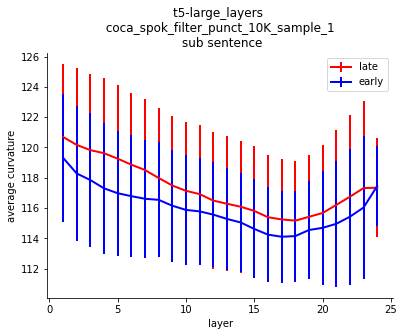

In [54]:

fig=plt.figure(figsize=(8,4))
ax = fig.add_axes((.3,.1,.6,.85))

ax.errorbar(np.arange(len(all_layer_curve_late)),np.mean(all_layer_curve_late,axis=1)*180/np.pi,yerr=np.std(all_layer_curve_late,axis=1)*180/np.pi,
            linewidth=2, color=(1,0,0),label='late')

ax.errorbar(np.arange(len(all_layer_curve_early)),np.mean(all_layer_curve_early,axis=1)*180/np.pi,yerr=np.std(all_layer_curve_early,axis=1)*180/np.pi,
            linewidth=2, color=(0,0,1),label='early')


ax.set_ylabel('average curvature')
ax.set_xlabel('layer')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(f"{group} \n {dataset} \n sub sentence")
ax.legend()



In [5]:
optimizer_id='coordinate_ascent_eh-obj=D_s_var-n_iter=50-n_samples=25-n_init=1-run_gpu=True'
optim_obj=optim_pool[optimizer_id]()
optim_obj.load_extractor(test)
del test


optimizer_obj = optim_pool[optimizer_id]()
optimizer_obj.load_extractor(extractor_obj)
del extractor_obj

In [6]:
layer_id_list=[x['layer'] for x in optim_obj.activations]

In [7]:
scores = pd.read_csv(os.path.join(SAVE_DIR, 'scoresscoresscores', 'scores-Pereira2018-encoding-normalized.csv'))
score_layer = list(scores['layer'][scores['model'] == mdl_name])
score_benchmark = list(scores['benchmark'][scores['model'] == mdl_name])
score_score = np.asarray(scores['score'][scores['model'] == mdl_name])
score_error = np.asarray(scores['error'][scores['model'] == mdl_name])

In [8]:
model_classes=['glove','ETM','word2vec','lm_1b','skip-thoughts','bert-','roberta','xlm','xlm-roberta-'
    ,'transfo-xl','xlnet','ctrl','t5','albert-','gpt']
color_groups=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
  'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [9]:
color_ids=[]
model_set=scores['model'].unique()
model_perf=[]
model_perf_untrained=[]
model_names=[]
model_layer_ids=[]
for model_id in model_set:
    model_score=scores['score'][scores['model']==model_id]
    model_error=scores['error'][scores['model']==model_id]
    model_layer_=scores['layer'][scores['model']==model_id]
    if model_id.find('untrained')==-1:
        model_perf.append([model_score.max(),model_error[model_score.idxmax()]])
        model_names.append(f"{model_id} ({model_layer_[model_score.idxmax()]})")
        model_layer_ids.append(model_layer_)
        # get untrained score 
        model_score_untr=list(scores['score'][scores['model']==f"{model_id}-untrained"])
        model_error_untr=list(scores['error'][scores['model']==f"{model_id}-untrained"])  
        model_perf_untrained.append([model_score_untr[np.argmax(model_score)],model_error_untr[np.argmax(model_score)]])


        if model_id=='xlm-roberta-base' or model_id=='xlm-roberta-large':
                color_loc=8
        else:
                color_loc=int(np.argwhere([model_id.find(x)!=-1  for x in model_classes])[-1].squeeze())
        color_ids.append(color_loc)


In [10]:
num_cols=[len(np.where(np.asarray(color_ids)==x)[0]) for idx, x in enumerate(np.unique(color_ids))]
h0s=[cm.get_cmap(color_groups[x],num_cols[idx]+2) for idx, x in enumerate(np.unique(color_ids))]
all_colors=[np.flipud(x(np.arange(num_cols[idx])/(num_cols[idx]+1))) for idx, x in enumerate(h0s)]
    #all_colors=[x(np.arange(num_cols[idx])/(num_cols[idx]+1)) for idx, x in enumerate(h0s)],
all_colors = [item for sublist in all_colors for item in sublist]

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

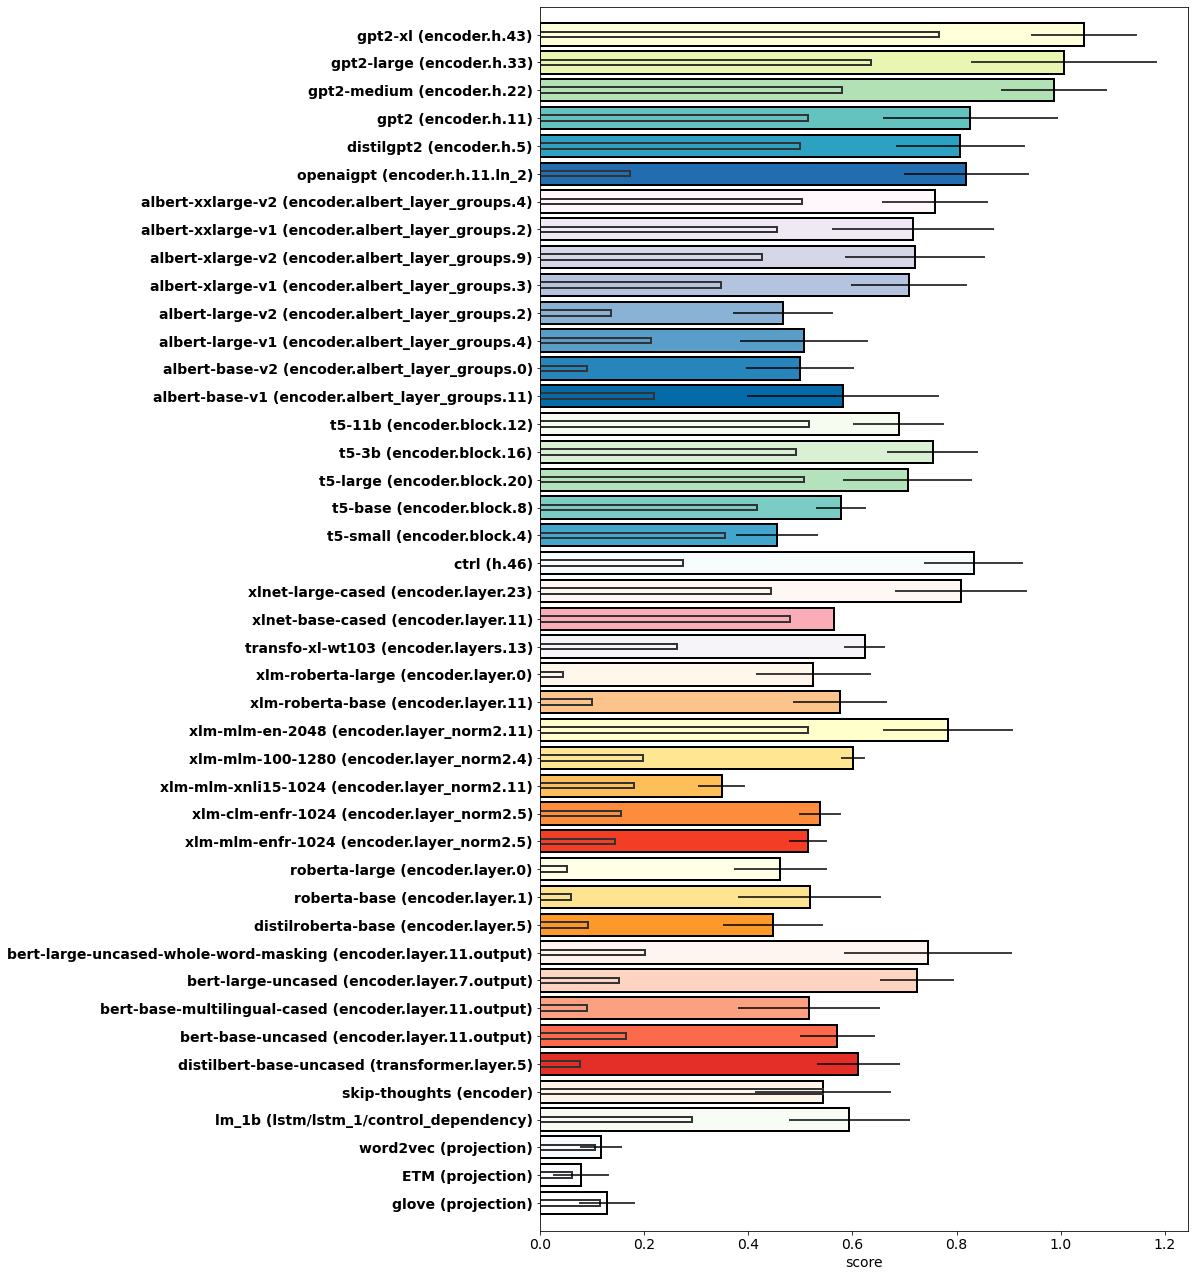

In [11]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.1,.6,.85))
ax.barh(y_pos, np.asarray(model_perf)[:,0], xerr=np.asarray(model_perf)[:,1], align='center',color=np.asarray(all_colors),edgecolor=(0,0,0),linewidth=2)
ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.2, align='center',color=np.asarray(all_colors),edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

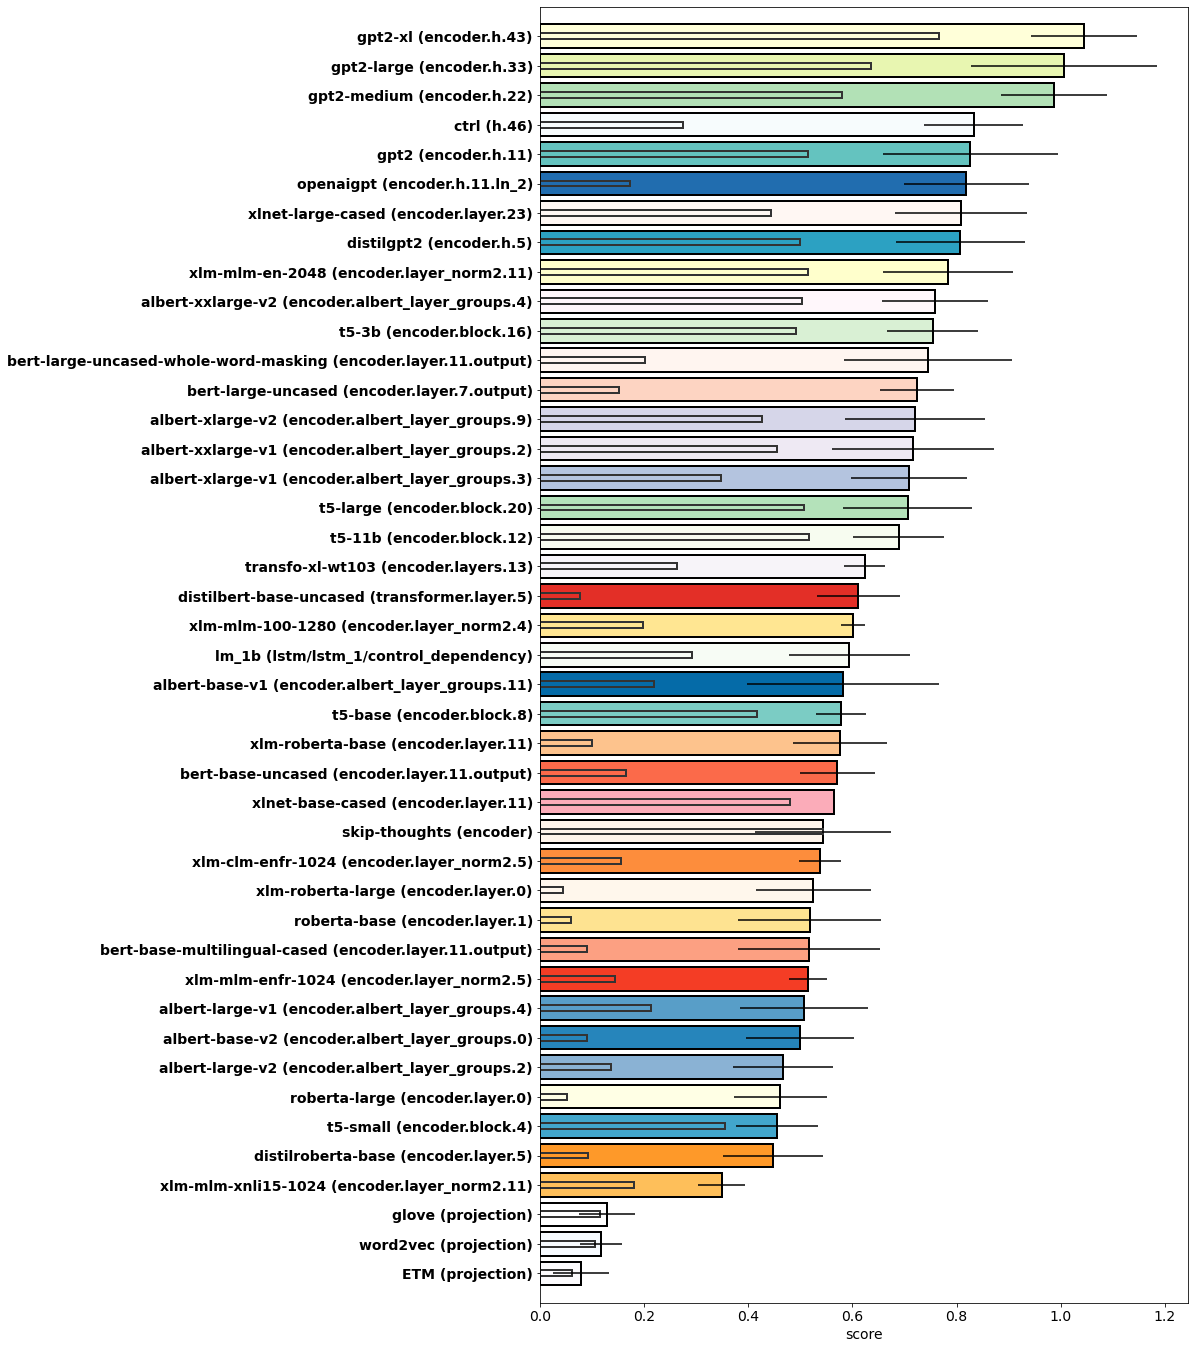

In [12]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
new_order=np.argsort(np.asarray(model_perf)[:,0])
ax.barh(y_pos, np.asarray(model_perf)[new_order,0], xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.2, align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

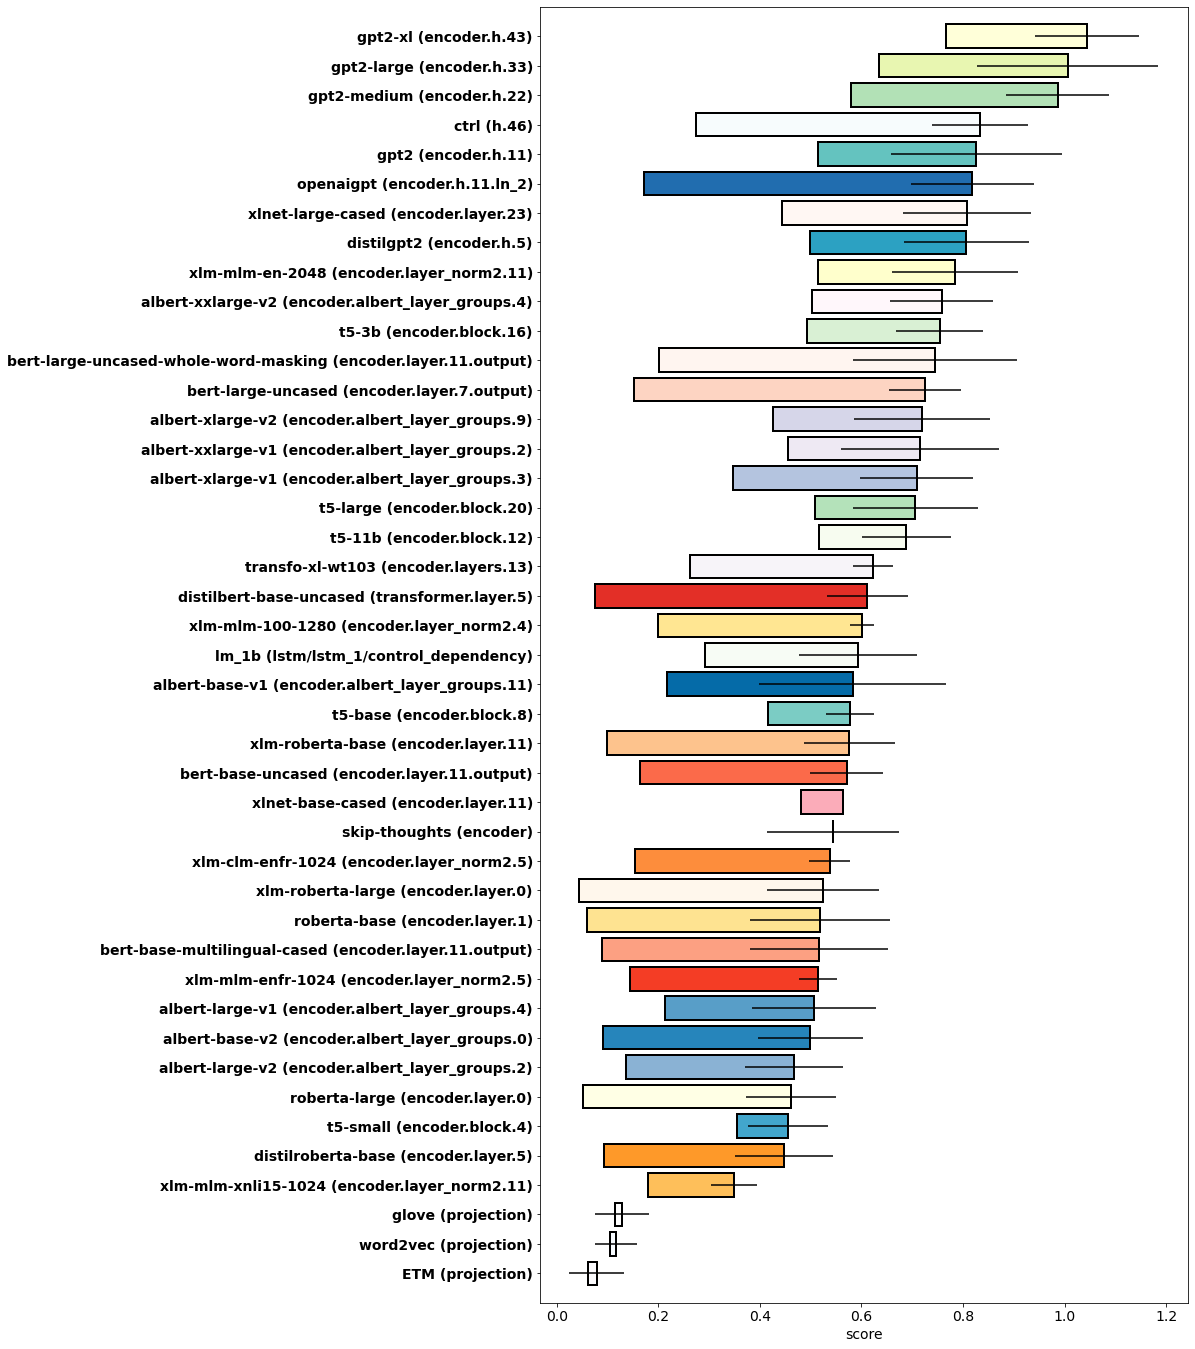

In [13]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
new_order=np.argsort(np.asarray(model_perf)[:,0])
baselines=np.asarray(model_perf_untrained)[new_order,0]
ax.barh(y_pos, np.asarray(model_perf)[new_order,0]-baselines,left=baselines, xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
#ax.barh(y_pos, np.asarray(model_perf_untrained)[new_order,0],height=0.8, align='center',color=(1,1,1),edgecolor=(1,1,1),linewidth=2)
ax.set_yticks(y_pos)
model_names_order=[model_names[x] for x in new_order]
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
ax.set_xlabel('score',fontsize=14)
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

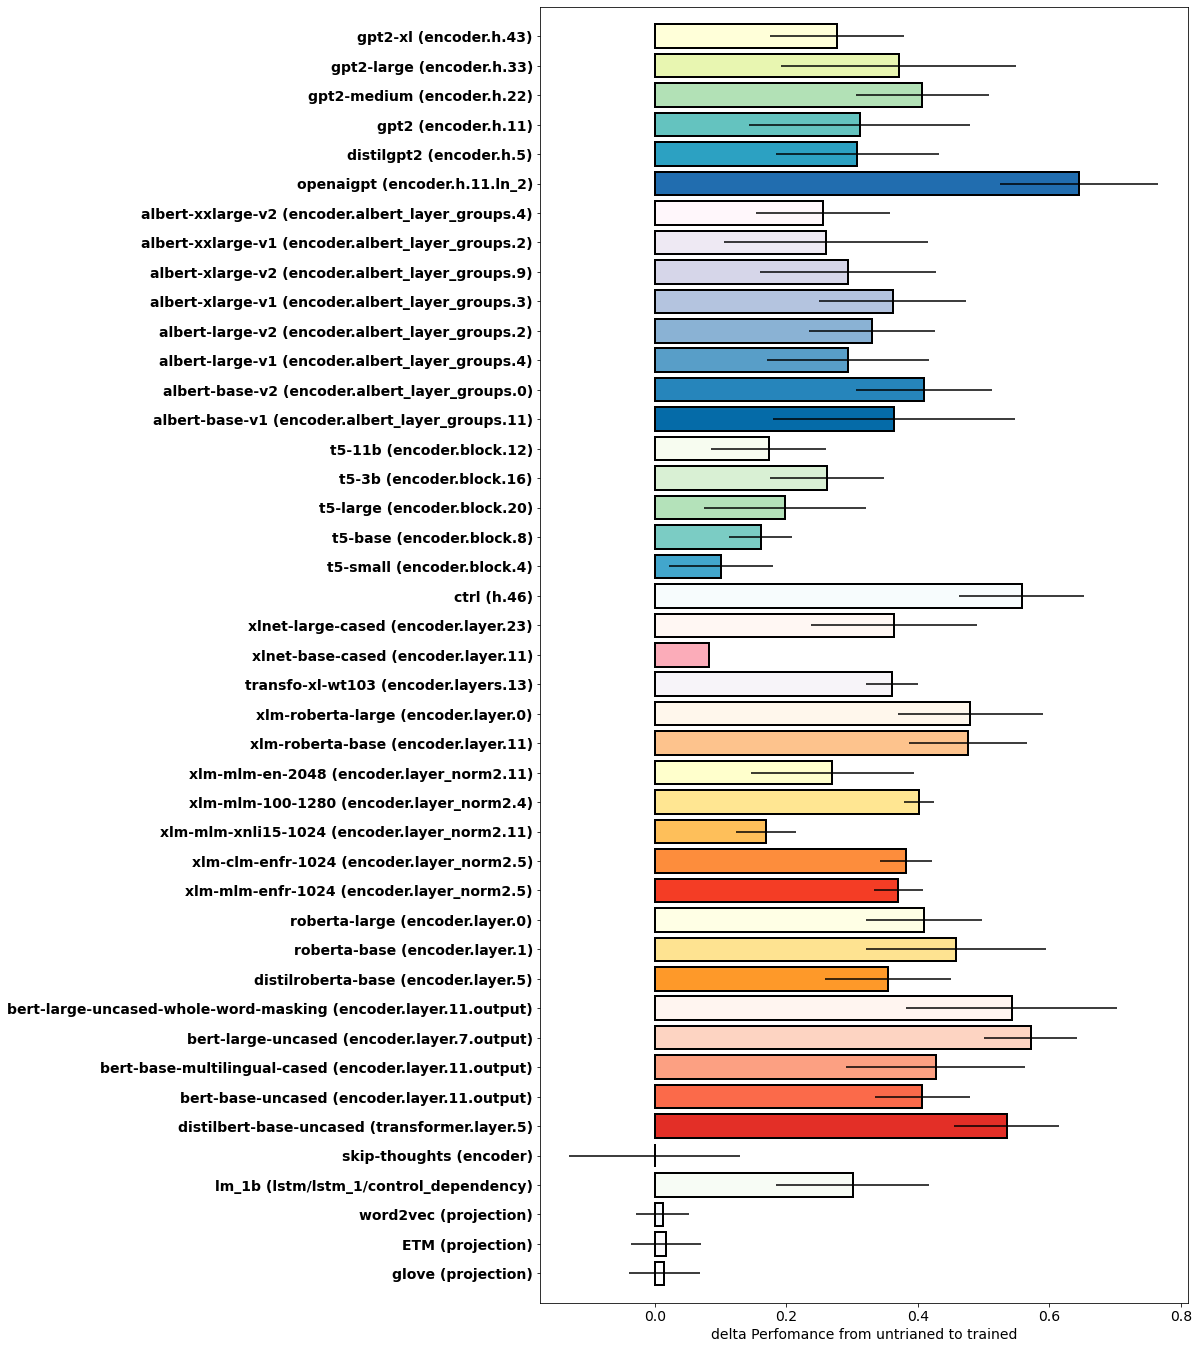

In [14]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
ax.barh(y_pos, np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0], xerr=np.asarray(model_perf)[:,1], align='center',color=np.asarray(all_colors),edgecolor=(0,0,0),linewidth=2)
#ax.barh(y_pos, np.asarray(model_perf_untrained)[:,0],height=0.2, align='center',color=np.asarray(all_colors),edgecolor=(.2,.2,.2),linewidth=2)
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names,fontsize=12,fontweight='bold')
ax.set_xlabel('delta Perfomance from untrianed to trained',fontsize=14)

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

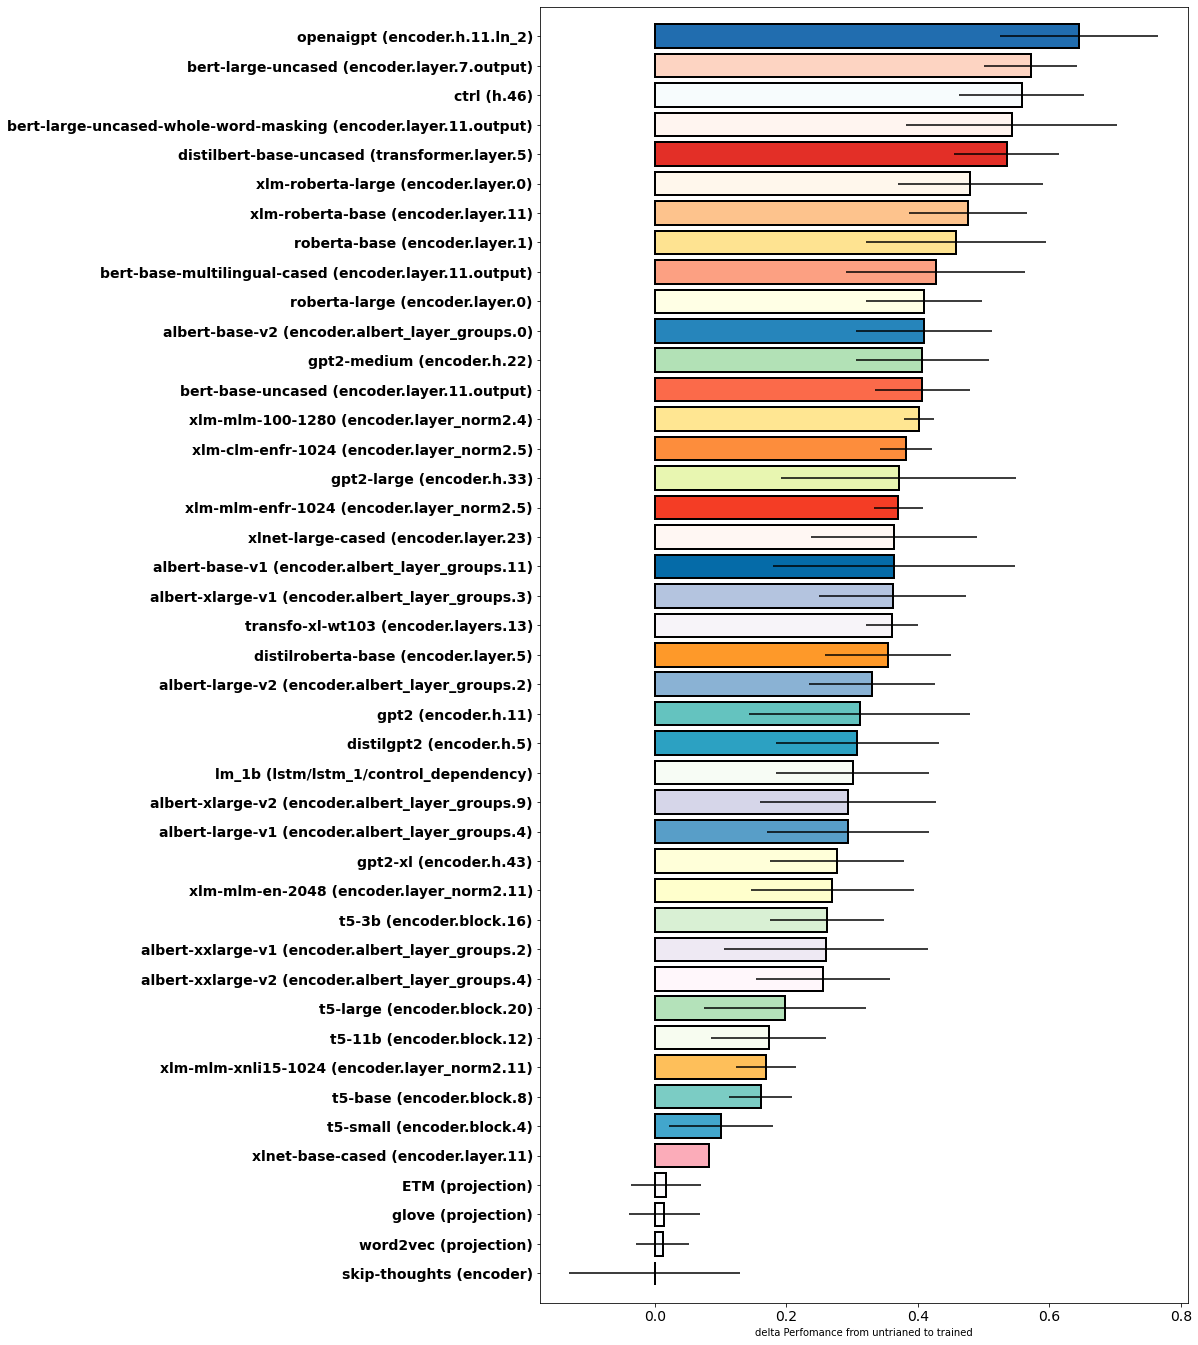

In [15]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1], align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)

ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

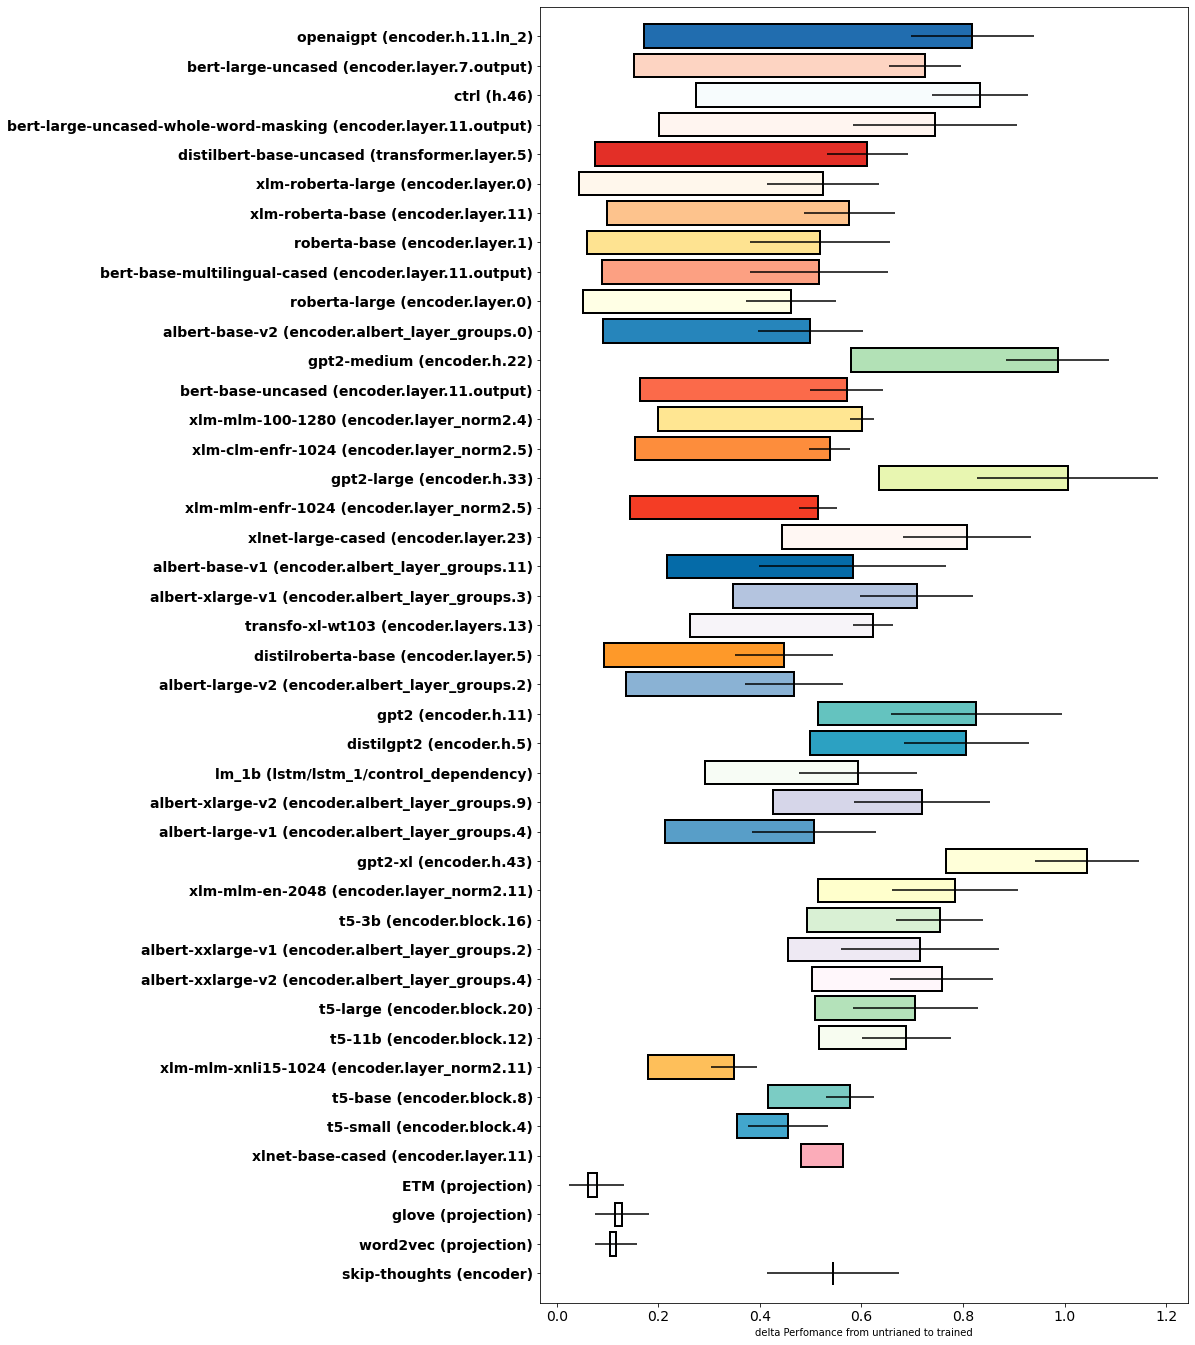

In [16]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
baseline_perf=np.asarray(model_perf_untrained)[:,0]
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1],left=baseline_perf[new_order],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)

ax.set_xlabel('delta Perfomance from untrianed to trained')

ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.set_yticklabels(model_names_order,fontsize=14,fontweight='bold')
plt.xticks(fontsize=14)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


(array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(-1.0, 0, '1.0'),
  Text(-0.8, 0, '0.8'),
  Text(-0.6, 0, '0.6'),
  Text(-0.3999999999999999, 0, '0.4'),
  Text(-0.19999999999999996, 0, '0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.20000000000000018, 0, '0.2'),
  Text(0.40000000000000013, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

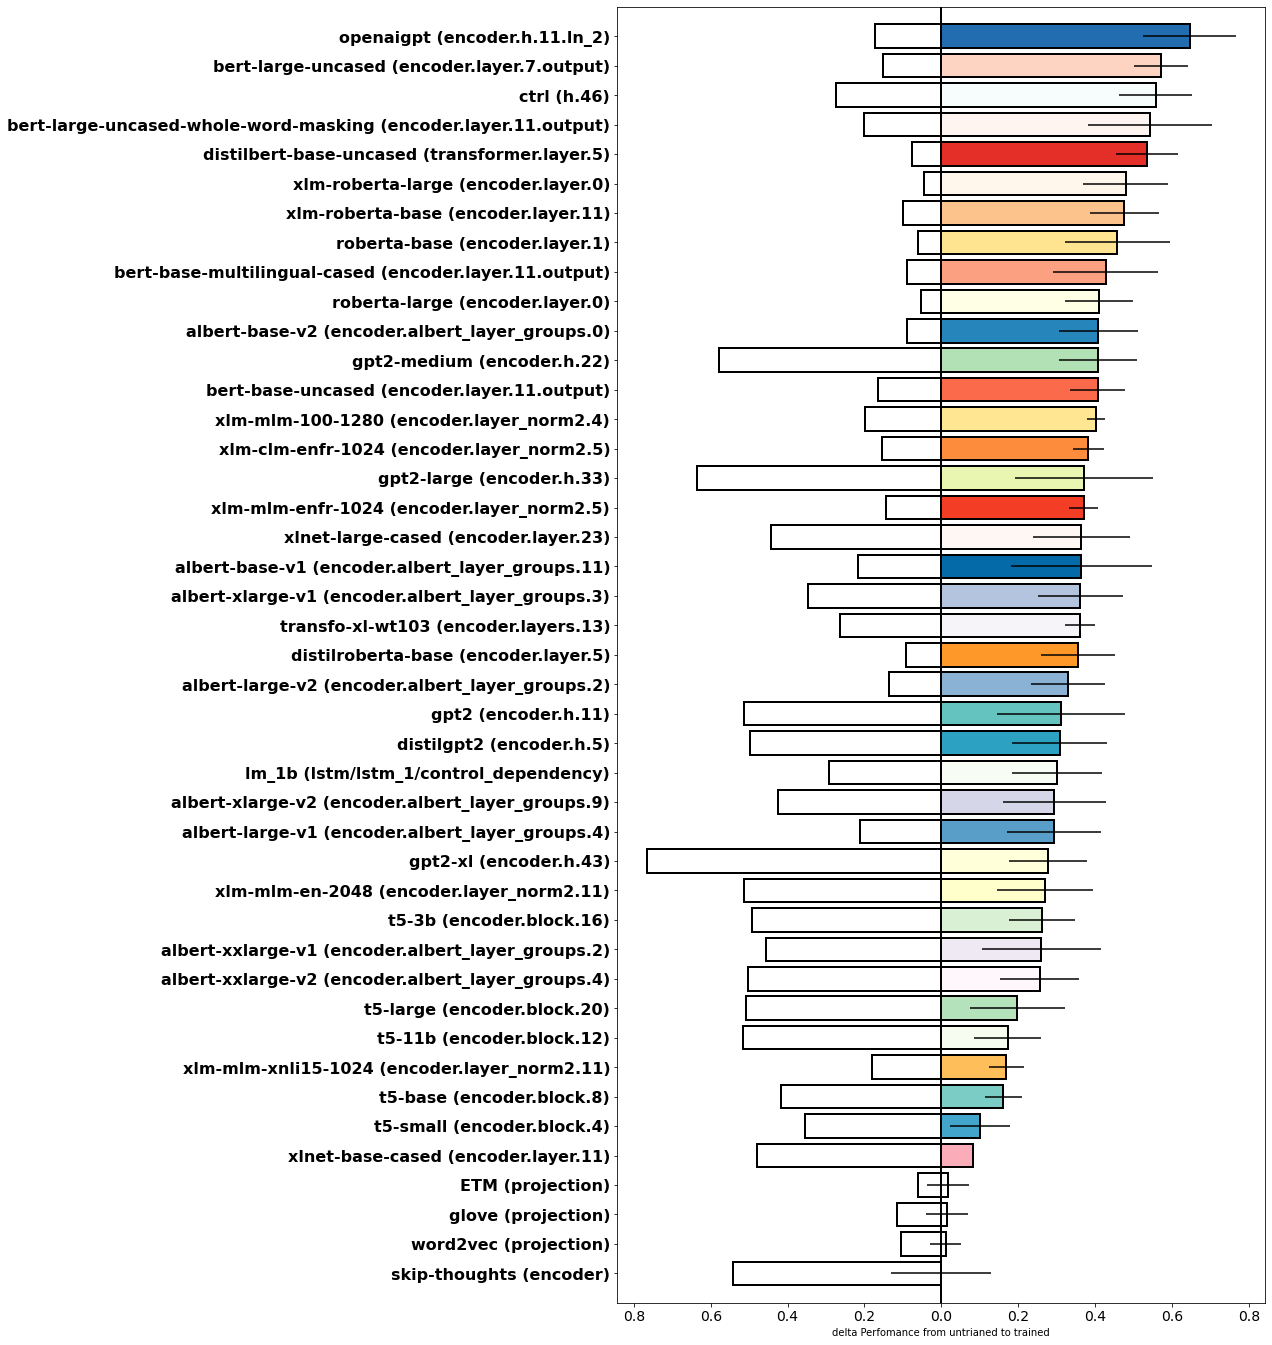

In [17]:
y_pos = np.arange(len(model_names))
fig=plt.figure(figsize=(15,20))
ax = fig.add_axes((.3,.05,.6,.9))
perf_diff=np.asarray(model_perf)[:,0]-np.asarray(model_perf_untrained)[:,0]
new_order=np.argsort(perf_diff)
baseline_perf=np.asarray(model_perf_untrained)[:,0]
ax.barh(y_pos, perf_diff[new_order], xerr=np.asarray(model_perf)[new_order,1],align='center',color=np.asarray(all_colors)[new_order,:],edgecolor=(0,0,0),linewidth=2),
ax.barh(y_pos, -1*baseline_perf[new_order],align='center',color=(1,1,1),edgecolor=(0,0,0),linewidth=2),
ax.set_ylim(y_pos.min()-1,y_pos.max()+1)
ax.plot([0,0],[y_pos.min()-1,y_pos.max()+1],'k-',linewidth=2)

model_names_order=[model_names[x] for x in new_order]
ax.set_yticks(y_pos)
labels = ["{0:.1f}".format(x) for x in np.abs(ax.get_xticks())]
ax.set_xticklabels(labels)
ax.set_xlabel('delta Perfomance from untrianed to trained')


ax.set_yticklabels(model_names_order,fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)

In [18]:
labels = ["{0:.1f}".format(x) for x in np.abs(ax.get_xticks())]


In [19]:
activation_list=[]
var_explained=[]
loadings=[]
components=[]
pca_type='fixed'
for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
    act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
    # act must be in m sample * n feature shape ,
    u,s,v=torch.pca_lowrank(act,q=500)
    # keep 85% variance explained ,
    idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
    cols=list(torch.where(idx_85)[0].cpu().numpy())
    if pca_type=='fixed':
            act_pca = torch.matmul(act, v[:, :300])
    elif pca_type=='equal_var':
            act_pca = torch.matmul(act, v[:, cols])
        
    activation_list.append(act_pca)
    var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
    #var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
var_explained=torch.stack(var_explained).cpu()

13it [00:25,  1.97s/it]


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


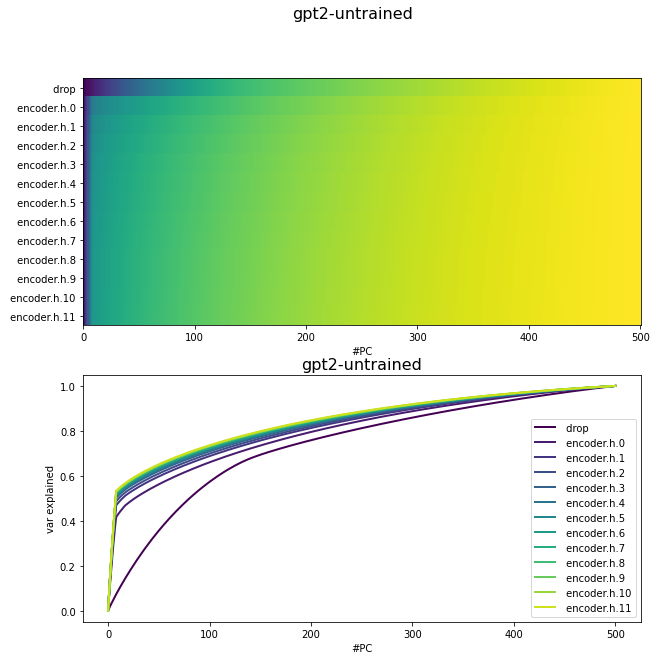

In [20]:
num_colors=len(activation_list)+1
h0=cm.get_cmap('viridis_r',num_colors)
line_cols=np.flipud(h0(np.arange(num_colors)/num_colors))
plt.figure(figsize=(10,10))
plt.suptitle(f"{mdl_name}\n",fontsize=16)
ax=plt.subplot(2,1,1)
ax.imshow(var_explained.cpu().numpy(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ])
ax.set_xlabel('#PC')

ax=plt.subplot(2,1,2)
[ax.plot(x,color=line_cols[idx,:],linewidth=2,label=f" {model_layers[idx]}") for idx,x in enumerate(var_explained)]
ax.legend()
ax.set_xlabel('#PC')
ax.set_ylabel('var explained')
ax.set_title(f"{mdl_name}",fontsize=16)
plt.savefig(os.path.join(ANALYZE_DIR,f"{extractor_id}_layer_var_explained.png"), dpi=None, facecolor='w', edgecolor='w',
               orientation='landscape',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


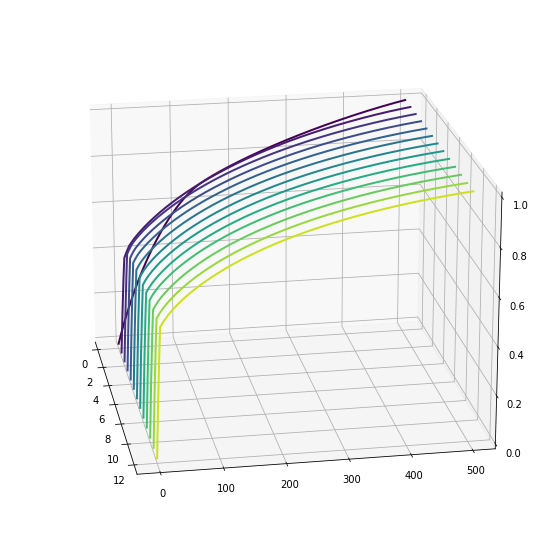

In [21]:
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10,10))
ax=plt.subplot(1,1,1, projection='3d')
[ax.plot((x*0+idx).cpu(),np.arange(x.shape[0]),x,color=line_cols[idx,:],linewidth=2,label=f" {model_layers[idx]}") for idx,x in enumerate(var_explained)]
ax.set_zlim((0,1))
ax.view_init(20, -10)

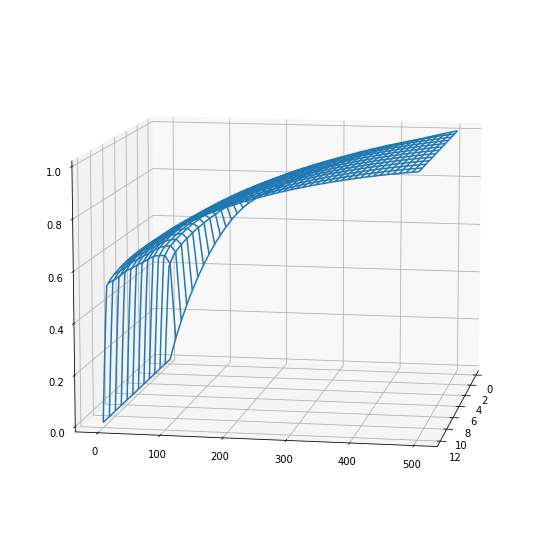

In [22]:
from mpl_toolkits.mplot3d import axes3d
X=torch.stack([(x*0+idx).cpu() for idx,x in enumerate(var_explained)])
Y=np.stack([np.arange(x.shape[0]) for idx,x in enumerate(var_explained)])
Z=torch.stack([x for idx,x in enumerate(var_explained)])


#XX=[[(x*0+idx).cpu(),np.arange(x.shape[0]),x] for idx,x in enumerate(var_explained)]
#XX=[[(x*0+idx).cpu(),np.arange(x.shape[0]),x] for idx,x in enumerate(var_explained)]
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10,10))
ax=plt.subplot(1,1,1, projection='3d')
ax.set_zlim((0,1))
ax.view_init(10, 10)
ax.plot_wireframe(X, Y, Z, rstride=1, cstride=10)

In [23]:
act_list_norm=[(X-X.mean(axis=1,keepdim=True)) for X in activation_list]
act_list_norm=[torch.nn.functional.normalize(X) for X in act_list_norm]

In [24]:
num_iter=5
total_sent=activation_list[0].shape[0]
num_samples=100
layer_dist=[]
for idx in tqdm_notebook(range(len(activation_list))):
    pair_dist=[]
    for idy in tqdm_notebook(range(len(activation_list)),position=1):
        sample_dist=[]
        for sample_iter in range(num_iter):
            samples=np.random.choice(total_sent,100,replace=False)
            X=act_list_norm[idx][samples,:]
            Y=act_list_norm[idy][samples,:]
            XY_corr=torch.tensor(1,device=X.device,dtype = float,requires_grad=False)-torch.mm(X,torch.transpose(Y,1,0))
            sample_dist.append(torch.diag(XY_corr))
        pair_dist.append(torch.mean(torch.stack(sample_dist),axis=1))
    layer_dist.append(pair_dist)
    print("Done!")

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/13 [00:00<?, ?it/s]

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


  0%|          | 0/13 [00:00<?, ?it/s]

Done!


Text(0, 0.5, 'score')

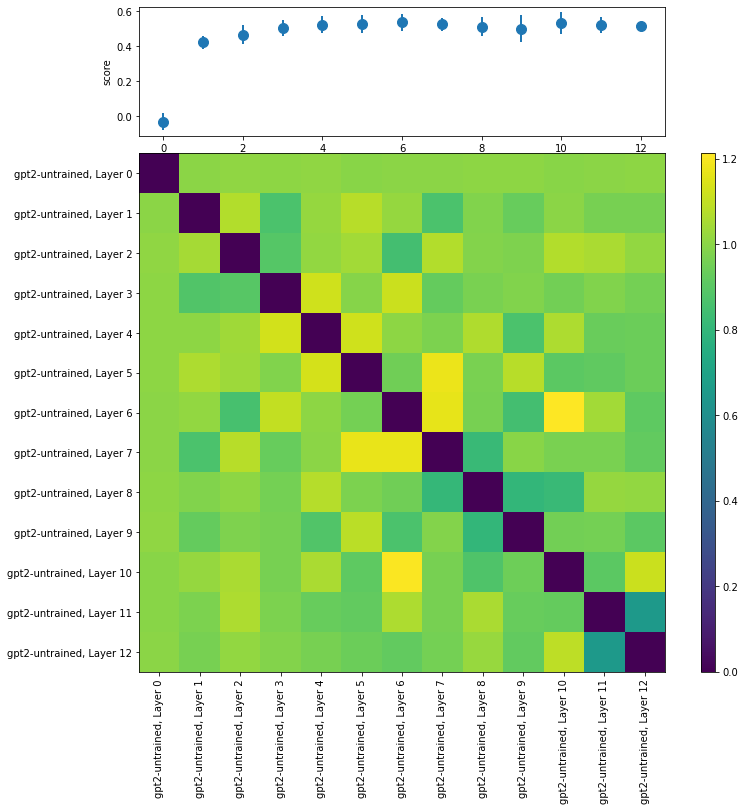

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10,12))
ax = fig.add_axes((.2,.1,.8,.6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.2, pad=0.5,)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}" for idx,x in enumerate(var_explained) ])
ax.set_xticklabels([f"{optim_obj.activations[idx]['model_name']}, Layer {optim_obj.activations[idx]['layer']}" for idx,x in enumerate(var_explained) ],rotation=90)

cbar = fig.colorbar(im, cax=cax)
ax = fig.add_axes((.2,.72,.73,.15))
ax.errorbar(np.arange(len(layer_id_list)),score_score[layer_id_list],yerr=score_error[layer_id_list],markersize=10,marker='o',linewidth=0,elinewidth=2,label=f'score {score_benchmark[0]}')
ax.set_ylabel('score')
#plt.savefig(os.path.join(ANALYZE_DIR,f\{name}_layerwise_corr_dist_vs_score.png\), dpi=None, facecolor='w', edgecolor='w',
#            orientation='landscape',,
#            transparent=True, bbox_inches=None, pad_inches=0.1,,
#            frameon=False)

# schematic of pair comaprisons 

In [26]:
num_samples=50
total_sent=activation_list[0].shape[0]
pair_list_norm=[act_list_norm[1],act_list_norm[3]]
XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in
                            pair_list_norm]
samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
XY_corr_sample=[X[samples,:] for X in XY_corr_list]
XY_corr_sample=[X[:,samples] for X in XY_corr_sample]
#pairs = torch.combinations(samples, with_replacement=False)
#XY_corr_sample = [XY_corr[pairs[:, 0], pairs[:, 1]] for XY_corr in XY_corr_list]
#XY_corr_sample_tensor = torch.stack(XY_corr_sample)
#XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
#if XY_corr_sample_tensor.shape[1] < XY_corr_sample_tensor.shape[0]:
#    XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
#assert (XY_corr_sample_tensor.shape[1] > XY_corr_sample_tensor.shape[0])
#d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=samples.device)
                #n1 = d_mat.shape[1],
                #correction = n1 * n1 / (n1 * (n1 - 1) / 2),
                #d_val = correction * d_mat.mean(dim=(0, 1)),
#d_val = d_mat[0,1]

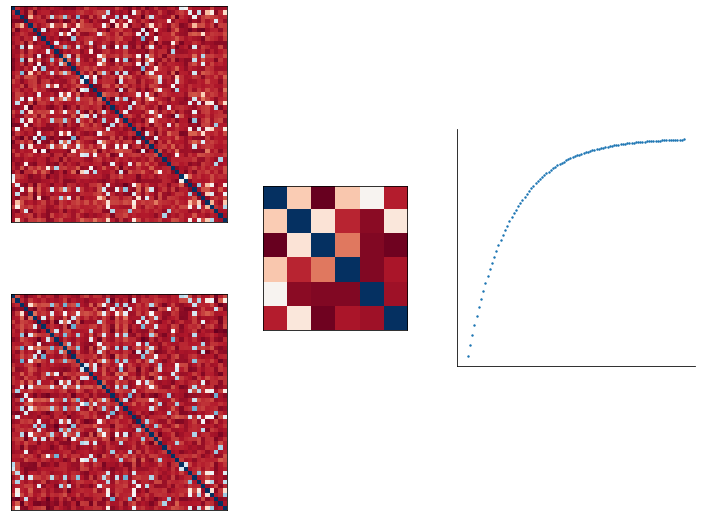

In [27]:
fig=plt.figure(figsize=(10,10))
#plt.suptitle(f"{mdl_name}\n",fontsize=16)
ax=fig.add_axes([.05,.5,.3,.3])
ax.imshow(XY_corr_sample[0].cpu().numpy(),aspect='auto',interpolation='none',cmap=plt.get_cmap('RdBu_r'))
ax.set_xticks([])
ax.set_yticks([])


ax=fig.add_axes([.05,.1,.3,.3])
ax.imshow(XY_corr_sample[1].cpu().numpy(),aspect='auto',interpolation='none',cmap=plt.get_cmap('RdBu_r'))
ax.set_xticks([])
ax.set_yticks([])



mixing=np.random.uniform(low=1,high=2,size=(6,6))
mixing=np.multiply(mixing,(1-np.eye(6)))
mixing=np.triu(mixing)
mixing=mixing+np.transpose(mixing)

ax1=fig.add_axes([.4,.35,.2,.2])
ax1.imshow(mixing,aspect='auto',interpolation='none',cmap=plt.get_cmap('RdBu_r'))
ax1.set_xticks([])
ax1.set_yticks([])



ax1=fig.add_axes([.67,.3,.33,.33])
time=np.linspace(0,1,100)
ax1.scatter(time,1-np.exp(-time*5),2)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()





In [28]:
num_iter=20
total_sent=activation_list[0].shape[0]
num_samples=100
layer_dist=[]
for idx in tqdm_notebook(range(len(activation_list))):
    pair_dist=[]
    for idy in tqdm_notebook(range(len(activation_list)),position=1):
        sample_dist=[]
        pair_list_norm=[act_list_norm[idx],act_list_norm[idy]]
        XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in
                            pair_list_norm]
        for sample_iter in range(num_iter):
            samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
            pairs = torch.combinations(samples, with_replacement=False)
            XY_corr_sample = [XY_corr[pairs[:, 0], pairs[:, 1]] for XY_corr in XY_corr_list]
            XY_corr_sample_tensor = torch.stack(XY_corr_sample)
            XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
            if XY_corr_sample_tensor.shape[1] < XY_corr_sample_tensor.shape[0]:
                XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
            assert (XY_corr_sample_tensor.shape[1] > XY_corr_sample_tensor.shape[0])
            d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=samples.device)
                #n1 = d_mat.shape[1],
                #correction = n1 * n1 / (n1 * (n1 - 1) / 2),
                #d_val = correction * d_mat.mean(dim=(0, 1)),
            d_val = d_mat[0,1]
            sample_dist.append(d_val)
        pair_dist.append(torch.stack(sample_dist))
    layer_dist.append(pair_dist)
print("Done!")

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/13 [00:00<?, ?it/s]

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Done!


In [29]:
#pereira_settings=extract_pool[extractor_id]
pereira_settings=extract_pool['group=best_performing_pereira_1-dataset=ud_sentences-activation-bench=None-ave=False']()

try :
    model_loc = pereira_settings.model_spec.index(mdl_name)
    pereira_layer_id=pereira_settings.layer_spec[model_loc]
except ValueError as e:
    pereira_layer_id=np.argmax(score_score)

In [30]:
Pereira_dist=torch.mean(torch.stack(layer_dist[pereira_layer_id]),dim=1)
dist_val,dist_idx=torch.sort(Pereira_dist)
assert(dist_idx[0]==pereira_layer_id)
cuts=np.linspace(dist_val.cpu().numpy().min(),dist_val.cpu().numpy().max(),4,endpoint=False)

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


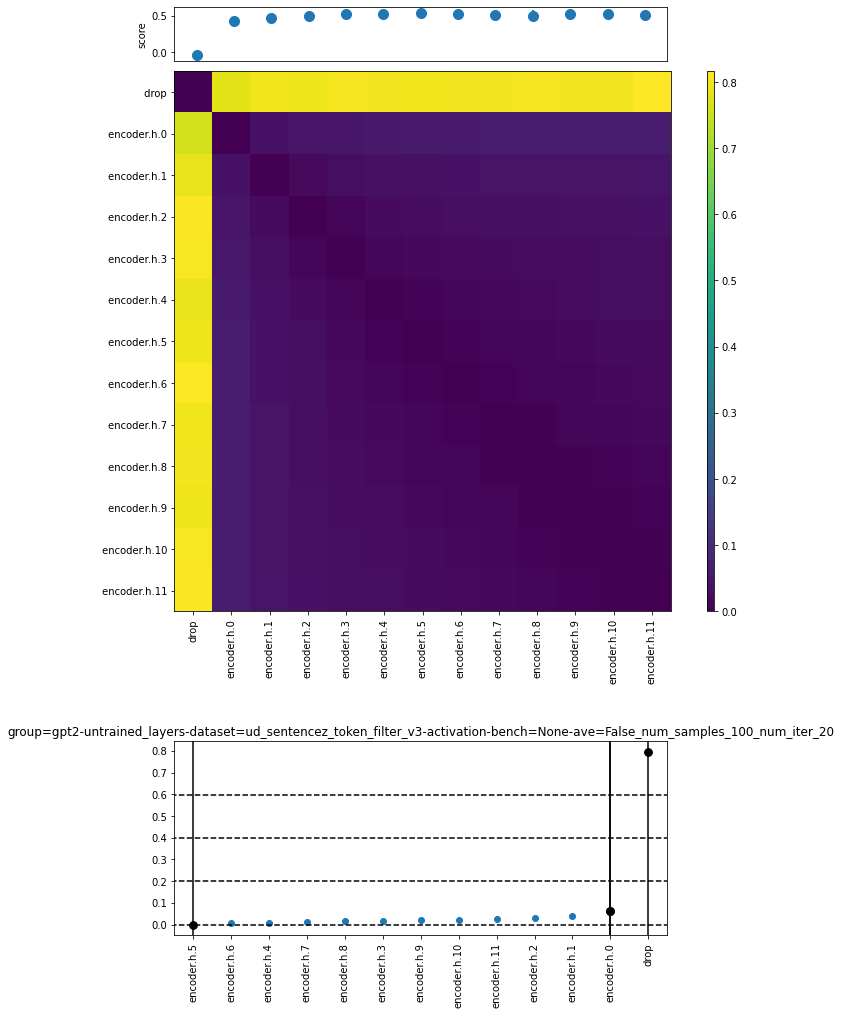

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10,15))
ax = fig.add_axes((.1,.4,.5*1.5,.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.1, pad=0.5)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ])
ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90)

cbar = fig.colorbar(im, cax=cax)
ax = fig.add_axes((.1,.91,.5*1.37,.05))
ax.errorbar(np.arange(len(layer_id_list)),score_score[layer_id_list],yerr=score_error[layer_id_list],markersize=10,marker='o',linewidth=0,elinewidth=2,label=f'score {score_benchmark[0]}')
ax.set_ylabel('score')
ax.set_xticks([])

ax = fig.add_axes((.1,.1,.5*1.37,.18))
ax.set_title(f"{extractor_id}_num_samples_{num_samples}_num_iter_{num_iter}")
ax.scatter(np.arange(dist_val.cpu().shape[0]),dist_val.cpu())
ax.set_xlim((-1,dist_val.cpu().shape[0]+1))
ax.set_ylim((0-.05,np.max(dist_val.cpu().numpy())+.05))
[ax.plot(plt.xlim(),[x,x],'k--') for x in cuts],
closest_points=[np.argmin(np.abs(dist_val.cpu()-x)) for x in cuts]
[ax.scatter(x.cpu().numpy(),dist_val[int(x.cpu().numpy())].cpu().numpy(),60,color=(0,0,0)) for x in closest_points]
ax.set_xticks(tuple(np.arange(dist_val.cpu().shape[0])))
    #ax.set_xticklabels(dist_idx.cpu().numpy()),
ax.set_xticklabels([model_layers[int(x)] for x in dist_idx.cpu().numpy()],rotation=90)
[ax.plot([x.cpu().numpy(),x.cpu().numpy()],plt.ylim(),'k-') for x in closest_points]
ax.set_xlim((0-.5,len(dist_idx)-.5))
plt.savefig(os.path.join(ANALYZE_DIR,f"{extractor_id}_num_samples_{num_samples}_num_iter_{num_iter}_layerwise_similiarty_dist_vs_score.png"), dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)  

[]